In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

In [2]:
data = np.loadtxt("D:/Backups/data/TracingTheCosmicWeb_PublicData/fof_catalog_200Mpc512.txt", skiprows=3)
N_real = len(data)
data = data[:N_real,[1,2,3]]
x = data[:,0]
y = data[:,1]
z = data[:,2]

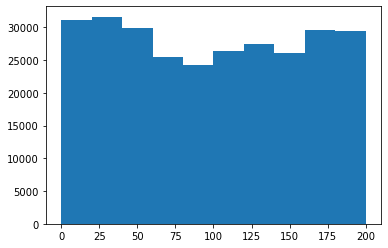

In [3]:
_ = plt.hist(z)

In [4]:
N_real

281465

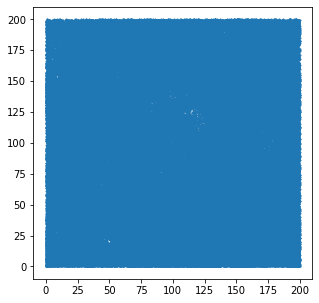

In [5]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y, s=1)
plt.plot()
plt.show()

In [6]:
df = pd.DataFrame(np.array([x, y, z]).T, columns=['X','Y','Z'])
np.savetxt('./data/pos_real.txt',df.values, fmt='%d')

# RF model

In [7]:
# start = time.time()
pos_file = "./data/pos_real.txt"
# os.system(f'wsl sh ./src/run_BSK.sh {pos_file} pos_real 1.0')

In [8]:
from src import bsk
import pickle
import h5py

In [10]:
# betafile = "./data/pos_real.BSKIndex"
# ca, cb = np.loadtxt(betafile, unpack = True)
# x,y,z = np.loadtxt(pos_file, unpack = True)
# ca = ca.astype(int)
# cb = cb.astype(int)

#----------------- Computing all features form b-skeleton
# Max = len(x)
# ID,nc,con = bsk.NumberConnections(Max,ca,cb)
# ad,vol,den = bsk.Features(Max,ID,x,y,z,nc,con)

# #----------------- New definitons of ad,nc, den
# ad = ad/np.mean(ad)    
# ncn = nc.astype(float)-np.median(nc.astype(float))
# den = np.log(den)

# Dnc, Dad, Dden = bsk.neigh_features(Max,ID,nc,ncn,ad,den,con)

#----------------- Saving all data in a hdf5 file
# f = h5py.File(f'./data/features_bsk.hdf5','w')
# dt = h5py.special_dtype(vlen=np.dtype('int64'))
# f.create_dataset('con', (len(con),), dtype=dt)
# f['con'][...] = con
# f.create_dataset('ID', data = ID)
# f.create_dataset('coor', data = (x,y,z))
# f.create_dataset('nc', data = ncn)
# f.create_dataset('ad', data = ad)
# f.create_dataset('vol', data = vol)
# f.create_dataset('den', data = den)
# f.create_dataset('Dnc', data = Dnc)
# f.create_dataset('Dad', data = Dad)
# f.create_dataset('Dden', data = Dden)
# f.close()

f = h5py.File(f'./data/features_bsk.hdf5','r')
nc = np.array(f['nc'])
ad = np.array(f['ad'])
den = np.array(f['den'])
Dnc = np.array(f['Dnc'])
Dad = np.array(f['Dad'])
Dden = np.array(f['Dden'])
f.close()

#------------ Reading the features
X = pd.DataFrame({'nc':nc,'ad':ad,'den':den,'Dnc':Dnc,'Dad':Dad,'Dden':Dden}) #

#------------ Loading the model
clf = pickle.load(open('./model/cosmicweb_bsk_model.sav','rb'))
env_pred = clf.predict(X)

np.savetxt(f'./data/envs_bsk+rf.txt', np.array(env_pred))
end = time.time()
print(f'Total time: {end - start}')

C:\Users\suare\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\suare\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


NameError: name 'start' is not defined

In [11]:
env_pred = np.loadtxt('./data/envs_bsk+rf.txt')
is_void     = env_pred == 3
is_sheet    = env_pred == 2
is_filament = env_pred == 1
is_peak     = env_pred == 0

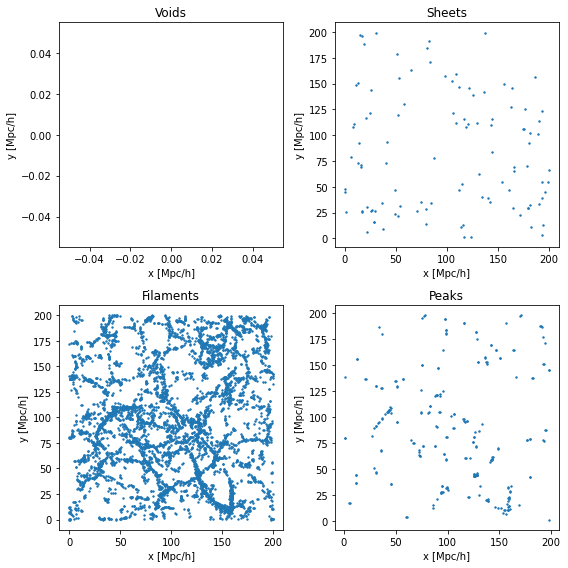

In [12]:
is_slice = (z>100) & (z<105)

fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(x[is_void & is_slice], y[is_void & is_slice], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Voids')

plt.subplot(2,2,2)
plt.scatter(x[is_sheet & is_slice], y[is_sheet & is_slice], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Sheets')

plt.subplot(2,2,3)
plt.scatter(x[is_filament & is_slice], y[is_filament & is_slice], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Filaments')

plt.subplot(2,2,4)
plt.scatter(x[is_peak & is_slice], y[is_peak & is_slice], s=2)
plt.title('Peaks')
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

plt.tight_layout()
plt.savefig('./figs/class_rf+bsk.png')
plt.show()

# Random Points Model

* Nrand == N
* $\beta$-skeleton

In [13]:
data_fake = np.random.random(size=(N_real,3))*200
points = np.vstack([data, data_fake])
np.shape(points)

(562930, 3)

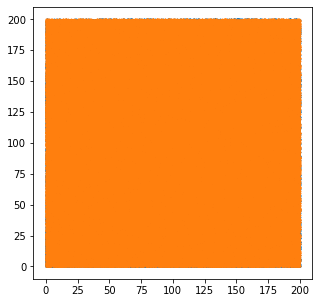

In [14]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y, s=1)
plt.scatter(data_fake[:,0],data_fake[:,1], s=1)
plt.plot()
plt.show()

In [15]:
print(len(x))
print(len(data_fake[:,0]))
x_total = np.concatenate([x,data_fake[:,0]])
y_total = np.concatenate([y,data_fake[:,1]])
z_total = np.concatenate([z,data_fake[:,2]])
print(len(x_total))

281465
281465
562930


In [16]:
pos_file_real_fake = './data/pos_real_fake.txt'
df = pd.DataFrame(np.array([x_total, y_total, z_total]).T, columns=['X','Y','Z'])
np.savetxt(pos_file_real_fake, df.values, fmt='%d')

## Random Points + 1-skeleton

In [17]:
start = time.time()
# os.system(f'wsl sh ./src/run_BSK.sh {pos_file_real_fake} pos_real_fake 1.0')

In [18]:
N_fake = N_real
nc_to_real  = np.zeros(N_real+N_fake)
nc_to_fake  = np.zeros(N_real+N_fake)
nc_total = np.zeros(N_real+N_fake)

In [19]:
conns = np.array(np.loadtxt('./data/pos_real_fake.BSKIndex'), dtype=int)

In [20]:
for con in conns:
    a = con[0]
    b = con[1]
    
    a_is_real = True
    b_is_real = True
    
    if a > N_real:  a_is_real = False
    if b > N_real:  b_is_real = False
    
    if a_is_real:   nc_to_real[b] += 1
    else:           nc_to_fake[b] += 1
        
    if b_is_real:   nc_to_real[a] +=1
    else:           nc_to_fake[a] +=1
        
nc_total = nc_to_real + nc_to_fake
end = time.time()
print(f'Total time: {end - start}')

Total time: 21.527472734451294


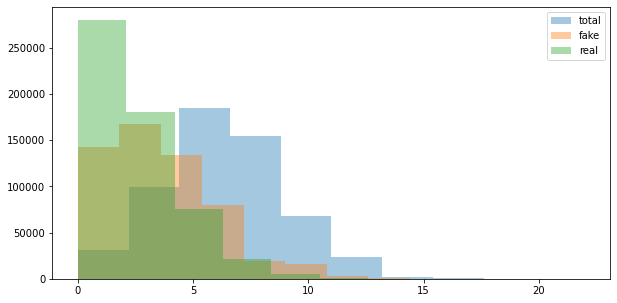

In [21]:
fig = plt.figure(figsize=(10,5))
_= plt.hist(nc_total, label='total', alpha=0.4)
_= plt.hist(nc_to_fake, label='fake', alpha=0.4)
_= plt.hist(nc_to_real, label='real', alpha=0.4)
plt.legend()
plt.show()

In [22]:
is_real     = np.arange(N_real+N_fake) < N_real
is_fake     = ~is_real
print(sum(is_real))

281465


### 1st Definition

In [23]:
min_connections = 4
more_fake_than_real   = nc_to_fake > nc_to_real
low_fake_connections  = nc_to_fake < min_connections
low_real_connections  = nc_to_real < min_connections

In [24]:
is_void     = (low_real_connections) & (more_fake_than_real)
is_filament = (~low_fake_connections) & (~more_fake_than_real)
is_sheet    = (~low_real_connections) & (more_fake_than_real)
is_peak     = (low_fake_connections) & (~more_fake_than_real)

In [27]:
envs = np.zeros(N_real)
envs[is_void[:N_real]] = 3
envs[is_sheet[:N_real]] = 2
envs[is_filament[:N_real]] = 1
envs[is_peak[:N_real]] = 0
df = pd.DataFrame(envs, columns=['envs'])
np.savetxt('./data/envs_bsk+fakepoints_1.txt', df.values)

In [28]:
is_slice = (z_total>100) & (z_total<105)
ii_void = is_real & is_void & is_slice
ii_fila = is_real & is_filament & is_slice
ii_sheet = is_real & is_sheet & is_slice
ii_peak = is_real & is_peak & is_slice

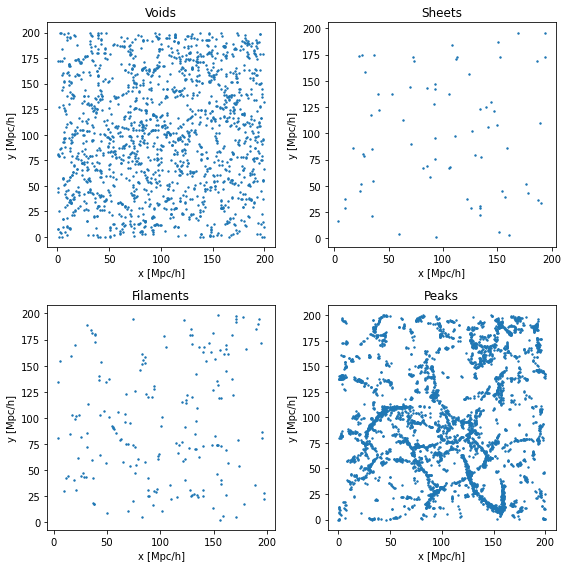

In [29]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(x_total[ii_void], y_total[ii_void], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Voids')

plt.subplot(2,2,2)
plt.scatter(x_total[ii_sheet], y_total[ii_sheet], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Sheets')

plt.subplot(2,2,3)
plt.scatter(x_total[ii_fila], y_total[ii_fila], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

plt.title('Filaments')

plt.subplot(2,2,4)
plt.scatter(x_total[ii_peak], y_total[ii_peak], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Peaks')

plt.tight_layout()
plt.savefig('./figs/class_bsk+fakepoints_1.png')
plt.show()

In [30]:
len(x_total), len(is_real), len(is_void)

(562930, 562930, 562930)

### 2nd Definition

In [31]:
is_void      =  ((nc_to_real == 0) & ( nc_total != 0 ) & (nc_to_fake != 0)) | (nc_total==0)
is_peak      =  (nc_to_fake == 0) & ( nc_total != 0 ) & (nc_to_real != 0)
is_sheet     =  (nc_to_fake  >=  nc_to_real) & ( nc_total != 0 ) & (nc_to_fake != 0) & (nc_to_real != 0)
is_filament  =  (nc_to_real  >   nc_to_fake) & ( nc_total != 0 ) & (nc_to_real != 0) & (nc_to_fake != 0)

In [32]:
envs = np.zeros(N_real)
envs[is_void[:N_real]] = 3
envs[is_sheet[:N_real]] = 2
envs[is_filament[:N_real]] = 1
envs[is_peak[:N_real]] = 0
df = pd.DataFrame(envs, columns=['envs'])
np.savetxt('./data/envs_bsk+fakepoints_2.txt', df.values)

In [33]:
is_slice = (z_total>100) & (z_total<105)
ii_void = is_real & is_void & is_slice
ii_fila = is_real & is_filament & is_slice
ii_sheet = is_real & is_sheet & is_slice
ii_peak = is_real & is_peak & is_slice

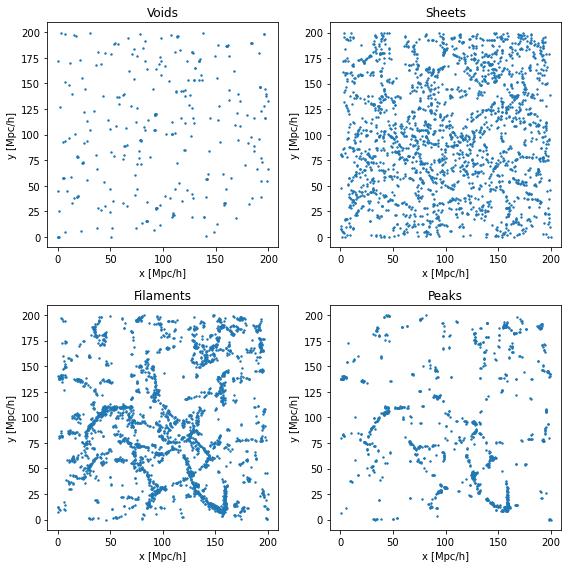

In [34]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(x_total[ii_void], y_total[ii_void], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Voids')

plt.subplot(2,2,2)
plt.scatter(x_total[ii_sheet], y_total[ii_sheet], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Sheets')

plt.subplot(2,2,3)
plt.scatter(x_total[ii_fila], y_total[ii_fila], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

plt.title('Filaments')

plt.subplot(2,2,4)
plt.scatter(x_total[ii_peak], y_total[ii_peak], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Peaks')

plt.tight_layout()
plt.savefig('./figs/class_bsk+fakepoints_2.png')
plt.show()

## Random points + Voronoi Graph

In [35]:
from scipy import spatial
import itertools

In [36]:
points = np.loadtxt(pos_file_real_fake)

In [37]:
start = time.time()
tri = spatial.Delaunay(points)

In [38]:
all_pairs = []
for simplex in tri.simplices:
    a = list(itertools.combinations(simplex,2))
    l = list(map(list, a))
    l = list(map(np.sort, l))
    l = list(map(list, l))
    all_pairs.append(l)
all_pairs = np.vstack(all_pairs)
unique_pairs = np.unique(all_pairs, axis=0)

In [39]:
N_fake = N_real
nc_to_real  = np.zeros(N_real+N_fake)
nc_to_fake  = np.zeros(N_real+N_fake)
nc_total = np.zeros(N_real+N_fake)

In [40]:
for con in unique_pairs:
    a = con[0]
    b = con[1]
    
    a_is_real = True
    b_is_real = True
    
    if a > N_real:  a_is_real = False
    if b > N_real:  b_is_real = False
    
    if a_is_real:   nc_to_real[b] += 1
    else:           nc_to_fake[b] += 1
        
    if b_is_real:   nc_to_real[a] +=1
    else:           nc_to_fake[a] +=1
        
nc_total = nc_to_real + nc_to_fake
end = time.time()
print(f'Total time: {end - start}')

Total time: 315.0712368488312


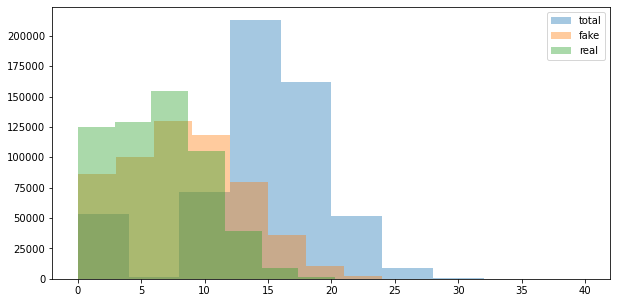

In [41]:
fig = plt.figure(figsize=(10,5))
_= plt.hist(nc_total, label='total', alpha=0.4)
_= plt.hist(nc_to_fake, label='fake', alpha=0.4)
_= plt.hist(nc_to_real, label='real', alpha=0.4)
plt.legend()
plt.show()

### 1st Definition

In [42]:
min_connections = 4
more_fake_than_real   = nc_to_fake > nc_to_real
low_fake_connections  = nc_to_fake < min_connections
low_real_connections  = nc_to_real < min_connections

In [43]:
is_void     = (low_real_connections) & (more_fake_than_real)
is_filament = (~low_fake_connections) & (~more_fake_than_real)
is_sheet    = (~low_real_connections) & (more_fake_than_real)
is_peak     = (low_fake_connections) & (~more_fake_than_real)

In [44]:
envs = np.zeros(N_real)
envs[is_void[:N_real]] = 3
envs[is_sheet[:N_real]] = 2
envs[is_filament[:N_real]] = 1
envs[is_peak[:N_real]] = 0
df = pd.DataFrame(envs, columns=['envs'])
np.savetxt('./data/envs_voronoi+fakepoints_1.txt', df.values)

In [45]:
is_slice = (z_total>100) & (z_total<105)
ii_void = is_real & is_void & is_slice
ii_fila = is_real & is_filament & is_slice
ii_sheet = is_real & is_sheet & is_slice
ii_peak = is_real & is_peak & is_slice

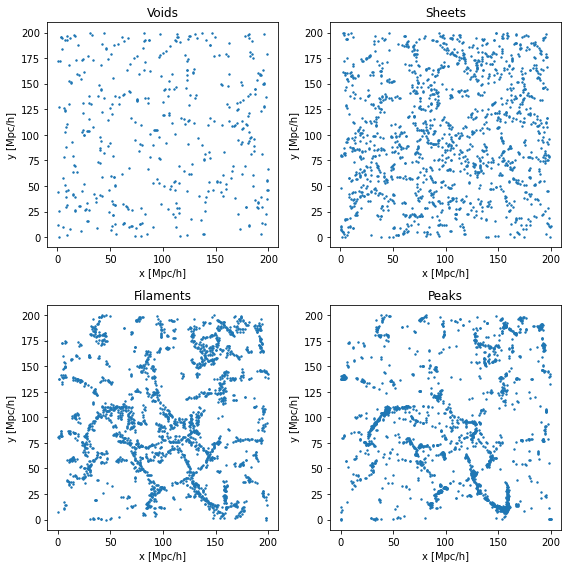

In [46]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(x_total[ii_void], y_total[ii_void], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Voids')

plt.subplot(2,2,2)
plt.scatter(x_total[ii_sheet], y_total[ii_sheet], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Sheets')

plt.subplot(2,2,3)
plt.scatter(x_total[ii_fila], y_total[ii_fila], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

plt.title('Filaments')

plt.subplot(2,2,4)
plt.scatter(x_total[ii_peak], y_total[ii_peak], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Peaks')

plt.tight_layout()
plt.savefig('./figs/class_voronoi+fakepoints_1.png')
plt.show()

### 2nd Definition

In [47]:
is_void      =  ((nc_to_real == 0) & ( nc_total != 0 ) & (nc_to_fake != 0)) | (nc_total==0)
is_peak      =  (nc_to_fake == 0) & ( nc_total != 0 ) & (nc_to_real != 0)
is_sheet     =  (nc_to_fake  >=  nc_to_real) & ( nc_total != 0 ) & (nc_to_fake != 0) & (nc_to_real != 0)
is_filament  =  (nc_to_real  >   nc_to_fake) & ( nc_total != 0 ) & (nc_to_real != 0) & (nc_to_fake != 0)

In [48]:
envs = np.zeros(N_real)
print(np.shape(envs))
envs[is_void[:N_real]] = 3
envs[is_sheet[:N_real]] = 2
envs[is_filament[:N_real]] = 1
envs[is_peak[:N_real]] = 0
df = pd.DataFrame(envs, columns=['envs'])
np.savetxt('./data/envs_voronoi+fakepoints_2.txt', df.values)

(281465,)


In [49]:
is_slice = (z_total>100) & (z_total<105)
ii_void = is_real & is_void & is_slice
ii_fila = is_real & is_filament & is_slice
ii_sheet = is_real & is_sheet & is_slice
ii_peak = is_real & is_peak & is_slice

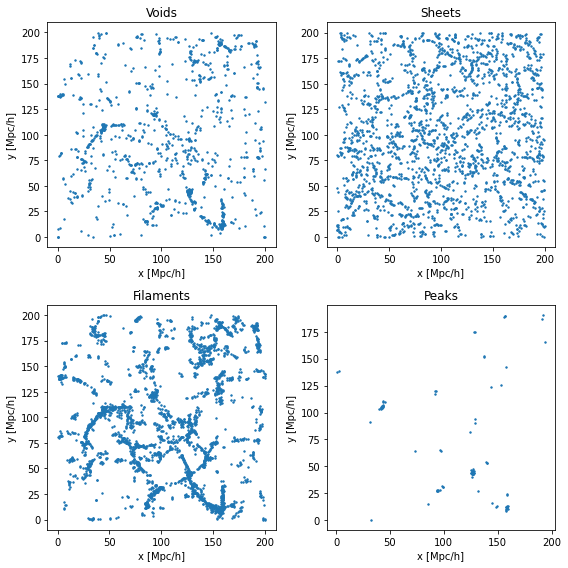

In [50]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(x_total[ii_void], y_total[ii_void], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Voids')

plt.subplot(2,2,2)
plt.scatter(x_total[ii_sheet], y_total[ii_sheet], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Sheets')

plt.subplot(2,2,3)
plt.scatter(x_total[ii_fila], y_total[ii_fila], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

plt.title('Filaments')

plt.subplot(2,2,4)
plt.scatter(x_total[ii_peak], y_total[ii_peak], s=2)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title('Peaks')

plt.tight_layout()
plt.savefig('./figs/class_voronoi+fakepoints_2.png')
plt.show()